<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Machine Learning Para Aplicações Biomédicas</font>
## <font color='blue'>Projeto 7</font>
## <font color='blue'>Geração de Sequência de Proteínas com Modelo de Transformadores</font>

## Pacotes Python Usados no Projeto

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark.
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [2]:
# Imports
import time
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [3]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [4]:
# Define o device
device = torch.device("cpu" if torch.backends.mps.is_built() else "cuda")
print("Device:", device)

Device: cpu


## Carregando e Compreendendo os Dados

In [5]:
# Define uma função que recebe um argumento o nome do arquivo
def dsa_carrega_dados(filename):
    
    # Abre o arquivo especificado pelo argumento filename em modo de leitura
    with open(filename) as f:
        
        # Carrega o conteúdo do arquivo em formato JSON e armazena na variável data
        data = json.load(f)
        
    # Retorna os dados carregados do arquivo
    return data

In [6]:
# Carrega os dados
sequences = dsa_carrega_dados("dados.json")

In [7]:
print(f"Número de sequências de proteínas: {len(sequences)}")

Número de sequências de proteínas: 42980


In [8]:
print(f"Amostra:\n", *sequences[:4], sep = "\n\n")

Amostra:


MAFLKKSLFLVLFLGVVSLSFCEEEKREEHEEEKRDEEDAESLGKRYGGLSPLRISKRVPPGFTPFRSPARSISGLTPIRLSKRVPPGFTPFRSPARRISEADPGFTPSFVVIKGLSPLRGKRRPPGFSPFRVD

MKLSTSLLAIVAVASTFIGNALSATTVPGCFAECIDKAAVAVNCAAGDIDCLQASSQFATIVSECVATSDCTALSPGSASDADSINKTFNILSGLGFIDEADAFSAADVPEERDLTGLGRVLPVEKRQNCPTRRGLCVTSGLTACRNHCRSCHRGDVGCVRCSNAQCTGFLGTTCTCINPCPRC

MASSSVEFRCFVGGLAWATDSNSLEKAFSVYGEIVEAKIVSDRETGRSRGFGFVTFLEEEAMRSAIEAMNGHILDGRNITVNEAQQRGGGGGGGYNRGGGYGGRRDGGGFSRGGGGGYGGGGGGGYGGGRDRGYGGGGGYGGGRDSRGSGGGGSEGGWRN

MEIKYLLTVFLVLLIVSDHCQAFLFSLIPHAISGLISAFKGRRKRDLDGQIDRFRNFRKRDAELEELLSKLPIY


## Explorando os Dados

In [9]:
# Verifica o tamanho (len) de cada sequência
seq_lens = [len(seq) for seq in sequences]

In [10]:
print(f"Comprimento Mínimo: {min(seq_lens)}")
print(f"Comprimento Máximo: {max(seq_lens)}")

Comprimento Mínimo: 40
Comprimento Máximo: 200


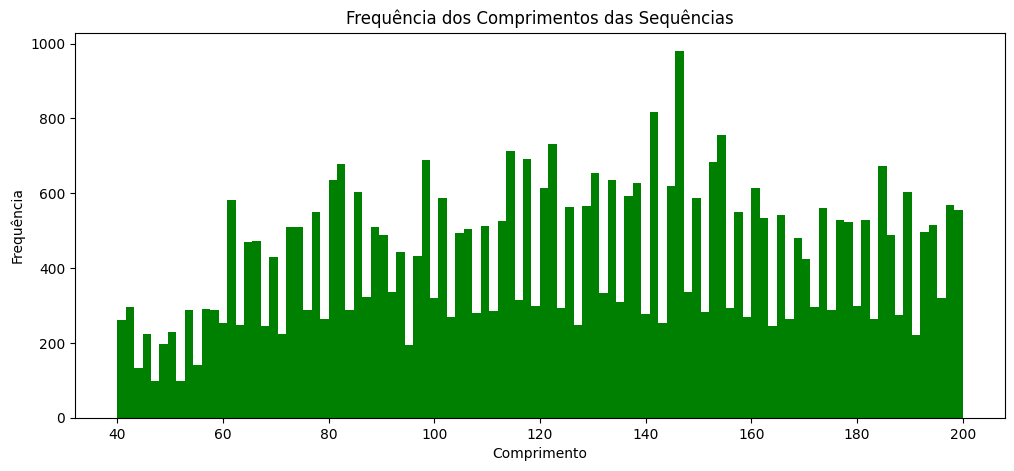

In [11]:
# Plot
plt.figure(figsize = (12, 5))
plt.title("Frequência dos Comprimentos das Sequências")
plt.hist(seq_lens, bins = 100, color = 'green')
plt.xlabel("Comprimento")
plt.ylabel("Frequência")
plt.show()

In [12]:
# Define uma função que recebe uma lista de sequências como argumento
def dsa_get_token_freq(sequences):
    
    # Inicializa um dicionário vazio para armazenar a frequência dos tokens
    token_freq = {}
    
    # Itera sobre cada sequência na lista de sequências
    for seq in sequences:
        
        # Itera sobre cada token na sequência atual
        for token in seq:
            
            # Verifica se o token ainda não está no dicionário de frequência
            if token not in token_freq:
                
                # Adiciona o token ao dicionário com uma contagem inicial de 0
                token_freq[token] = 0
            
            # Incrementa a contagem de frequência do token em 1
            token_freq[token] += 1
    
    # Retorna o dicionário contendo as frequências dos tokens
    return token_freq

In [13]:
# Retorna a frequência de cada token
aa_freq = dsa_get_token_freq(sequences)

In [14]:
# Ordena as chaves do dicionário
aa_sorted = sorted(aa_freq.keys(), key = lambda x: aa_freq[x], reverse = True)  

Essa linha de código acima ordena as chaves do dicionário aa_freq com base nos valores associados a essas chaves, do maior para o menor. Vamos detalhar como isso funciona:

**aa_freq.keys()**: Obtém todas as chaves do dicionário aa_freq.

**sorted(..., key=lambda x: aa_freq[x], reverse=True)**: Ordena essas chaves com base nos valores associados a cada chave em aa_freq.

**key=lambda x: aa_freq[x]**: Define uma função lambda que indica que cada chave deve ser ordenada de acordo com o valor correspondente em aa_freq. Ou seja, x é a chave e aa_freq[x] é o valor utilizado para a ordenação.

**reverse=True**: Ordena em ordem decrescente, do maior para o menor valor.

Assim, o resultado de aa_sorted será uma lista de chaves de aa_freq, ordenadas da maior para a menor frequência.

In [15]:
print(f"Número de aminoácidos diferentes: {len(aa_freq)}")

Número de aminoácidos diferentes: 24


In [16]:
print(f"Número total de aminoácidos: {sum(aa_freq.values()):,}")

Número total de aminoácidos: 5,413,916


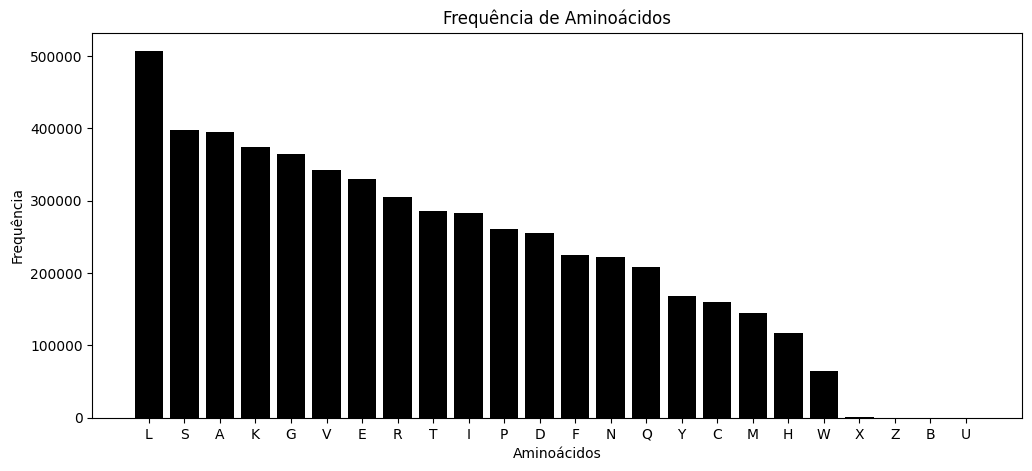

In [17]:
# Plot
plt.figure(figsize = (12, 5))
plt.title("Frequência de Aminoácidos")
plt.bar(range(len(aa_freq)), 
        [aa_freq[aa] for aa in aa_sorted], 
        align = "center", 
        tick_label = aa_sorted, 
        color = 'black')
plt.xlabel("Aminoácidos")
plt.ylabel("Frequência")
plt.show()

## Preparação dos Dados - Construindo o Vocabulário

In [18]:
# Cria o vocabulário
vocab = ["<pad>", "<bos>", "<eos>"] + aa_sorted

In [19]:
# Tamanho do vocabulário
vocab_size = len(vocab)

In [20]:
print(f"Tamanho do Vocabulário: {vocab_size}")

Tamanho do Vocabulário: 27


In [21]:
print(f"Vocabulário:", *vocab)

Vocabulário: <pad> <bos> <eos> L S A K G V E R T I P D F N Q Y C M H W X Z B U


In [22]:
# Construir mapeamento de token para índices (e vice-versa)
token2idx = {token: i for i, token in enumerate(vocab)}
idx2token = {i: token for i, token in enumerate(vocab)}

In [23]:
token2idx

{'<pad>': 0,
 '<bos>': 1,
 '<eos>': 2,
 'L': 3,
 'S': 4,
 'A': 5,
 'K': 6,
 'G': 7,
 'V': 8,
 'E': 9,
 'R': 10,
 'T': 11,
 'I': 12,
 'P': 13,
 'D': 14,
 'F': 15,
 'N': 16,
 'Q': 17,
 'Y': 18,
 'C': 19,
 'M': 20,
 'H': 21,
 'W': 22,
 'X': 23,
 'Z': 24,
 'B': 25,
 'U': 26}

In [24]:
idx2token

{0: '<pad>',
 1: '<bos>',
 2: '<eos>',
 3: 'L',
 4: 'S',
 5: 'A',
 6: 'K',
 7: 'G',
 8: 'V',
 9: 'E',
 10: 'R',
 11: 'T',
 12: 'I',
 13: 'P',
 14: 'D',
 15: 'F',
 16: 'N',
 17: 'Q',
 18: 'Y',
 19: 'C',
 20: 'M',
 21: 'H',
 22: 'W',
 23: 'X',
 24: 'Z',
 25: 'B',
 26: 'U'}

## Preparação dos Dados - Classe Para Estrutura de Dados

O padding no código abaixo refere-se ao processo de adicionar tokens especiais (neste caso, o token < pad >) ao final das sequências de entrada (input_ids) e de saída (target_ids) de modo a torná-las todas de um mesmo comprimento.

Em redes neurais que processam sequências de dados, como aquelas usadas em PLN (Processamento de Linguagem Natural), é comum que as sequências (como frases ou sentenças) tenham tamanhos variados. No entanto, os modelos de Deep Learning geralmente requerem que todas as sequências dentro de um batch tenham o mesmo comprimento, pois trabalham com matrizes de tamanho fixo. O padding resolve esse problema ao:

- Encontrar a sequência mais longa do batch (max_len).
- Adicionar o token de padding (< pad >) no final das sequências menores para que todas tenham o mesmo comprimento.

No caso específico abaixo, o padding é aplicado tanto aos input_ids (que são os IDs dos tokens de entrada) quanto aos target_ids (os IDs dos tokens de saída), e o token de padding é representado por self.token2idx["< pad >"], que é o índice correspondente ao token de padding no vocabulário.

Isso garante que todas as sequências dentro de um batch tenham o mesmo tamanho, permitindo que sejam processadas de forma eficiente por redes neurais.

In [25]:
# Define uma classe chamada DSAProteinDataset que herda de Dataset
class DSAProteinDataset(Dataset):
    
    # Inicializa a classe com uma lista de sequências e um dicionário token2idx
    def __init__(self, sequences, token2idx):
        
        # Armazena o mapeamento token para índice
        self.token2idx = token2idx
        
        # Inicializa listas vazias para armazenar os dados de sequência e os IDs dos dados
        self.data, self.data_id = [], []
        
        # Itera sobre cada sequência na lista de sequências
        for seq in sequences:
            
            # Adiciona tokens de início (<bos>) e fim (<eos>) à sequência
            tokens = ["<bos>"] + [token for token in seq] + ["<eos>"]
            
            # Adiciona a sequência de tokens à lista de dados
            self.data.append(tokens)
            
            # Converte os tokens da sequência para IDs usando o mapeamento e adiciona à lista de IDs
            self.data_id.append([token2idx[token] for token in self.data[-1]])

    # Retorna o tamanho do conjunto de dados
    def __len__(self):
        return len(self.data)

    # Retorna um item específico do conjunto de dados com base no índice
    def __getitem__(self, index):
        
        # Define input_ids como todos os IDs, exceto o último
        input_ids = self.data_id[index][:-1]
        
        # Define target_ids como todos os IDs, exceto o primeiro
        target_ids = self.data_id[index][1:]

        # Retorna input_ids e target_ids como uma tupla
        return input_ids, target_ids

    # Função para aplicar padding em um batch
    def padding_batch(self, batch):
        
        # Separa os input_ids e target_ids para cada item no batch
        input_ids = [d[0] for d in batch]
        target_ids = [d[1] for d in batch]

        # Calcula o comprimento máximo entre as sequências input_ids
        max_len = max([len(i) for i in input_ids])

        # Itera sobre cada sequência para aplicar o padding
        for i in range(len(input_ids)):
            
            # Adiciona tokens <pad> ao final de cada sequência input_ids para igualar o comprimento
            input_ids[i] += [self.token2idx["<pad>"]] * (max_len - len(input_ids[i]))
            
            # Adiciona tokens <pad> ao final de cada sequência target_ids para igualar o comprimento
            target_ids[i] += [self.token2idx["<pad>"]] * (max_len - len(target_ids[i]))

        # Converte input_ids para um tensor do tipo LongTensor
        input_ids = torch.LongTensor(input_ids)
        
        # Converte target_ids para um tensor do tipo LongTensor
        target_ids = torch.LongTensor(target_ids)

        # Retorna os tensores input_ids e target_ids
        return input_ids, target_ids

A lógica por trás de **input_ids = self.data_id[index][:-1]** e **target_ids = self.data_id[index][1:]** é comum em modelos de sequência, especialmente em tarefas de modelagem de linguagem e previsão de sequência. Vamos ver o propósito de cada um:

**input_ids = self.data_id[index][:-1]:**

Aqui, input_ids representa a sequência de entrada para o modelo, incluindo todos os tokens da sequência, exceto o último. O modelo utiliza essa sequência para prever o próximo token em cada posição.

**target_ids = self.data_id[index][1:]:**

Em target_ids, são incluídos todos os tokens, exceto o primeiro. Essa lista representa a sequência de saída ou a sequência-alvo para o modelo, com cada token alinhado como a "próxima palavra" para os tokens correspondentes em input_ids.

O objetivo dessa configuração é permitir que o modelo aprenda a prever o próximo token em uma sequência. Por exemplo:

Para uma sequência ["< bos >", "A", "B", "C", "< eos >"]:

**input_ids: ["< bos >", "A", "B", "C"]**

**target_ids: ["A", "B", "C", "< eos >"]**
    
Isso permite que o modelo receba < bos > e aprenda a prever A, depois receba A para prever B, e assim por diante, até o último token (C) prever < eos >. Essa abordagem é fundamental para treinar modelos em tarefas de previsão de sequência e modelagem de linguagem.

In [26]:
# Testando a classe
n_seq = 10
dataset = DSAProteinDataset(sequences[:n_seq], token2idx)

In [27]:
# Testando o dataset
idx = 0
input_ids, target_ids = dataset[idx]
input_tokens, target_tokens = [idx2token[i] for i in input_ids], [idx2token[i] for i in target_ids]

In [28]:
print(f"Sequência Original:", *sequences[idx])

Sequência Original: M A F L K K S L F L V L F L G V V S L S F C E E E K R E E H E E E K R D E E D A E S L G K R Y G G L S P L R I S K R V P P G F T P F R S P A R S I S G L T P I R L S K R V P P G F T P F R S P A R R I S E A D P G F T P S F V V I K G L S P L R G K R R P P G F S P F R V D


In [29]:
print(f"Sequência de Entrada do Conjunto de Dados:", *input_tokens)

Sequência de Entrada do Conjunto de Dados: <bos> M A F L K K S L F L V L F L G V V S L S F C E E E K R E E H E E E K R D E E D A E S L G K R Y G G L S P L R I S K R V P P G F T P F R S P A R S I S G L T P I R L S K R V P P G F T P F R S P A R R I S E A D P G F T P S F V V I K G L S P L R G K R R P P G F S P F R V D


In [30]:
print(f"Sequência de destino do conjunto de dados:", *target_tokens)

Sequência de destino do conjunto de dados: M A F L K K S L F L V L F L G V V S L S F C E E E K R E E H E E E K R D E E D A E S L G K R Y G G L S P L R I S K R V P P G F T P F R S P A R S I S G L T P I R L S K R V P P G F T P F R S P A R R I S E A D P G F T P S F V V I K G L S P L R G K R R P P G F S P F R V D <eos>


In [31]:
# Testando a função de preenchimento de lote com um lote fictício
batch = [
    [token2idx[i] for i in ['<bos>', 'A', 'B', 'C', '<eos>']],
    [token2idx[i] for i in ['<bos>', 'A', 'B', '<eos>']],
    [token2idx[i] for i in ['<bos>', 'A', '<eos>']],
    [token2idx[i] for i in ['<bos>', 'A', 'B', 'C', 'D', '<eos>']],
]

In [32]:
# Gera o batch
batch2 = [(b[:-1], b[1:]) for b in batch]

In [33]:
# Gera os ids
input_ids, target_ids = dataset.padding_batch(batch2)

In [34]:
print("Input batch:\n")
print(*[[idx2token[i] for i in x] for x in input_ids.tolist()], sep="\n")

Input batch:

['<bos>', 'A', 'B', 'C', '<pad>']
['<bos>', 'A', 'B', '<pad>', '<pad>']
['<bos>', 'A', '<pad>', '<pad>', '<pad>']
['<bos>', 'A', 'B', 'C', 'D']


In [35]:
print("Target batch:\n")
print(*[[idx2token[i] for i in x] for x in target_ids.tolist()], sep="\n")

Target batch:

['A', 'B', 'C', '<eos>', '<pad>']
['A', 'B', '<eos>', '<pad>', '<pad>']
['A', '<eos>', '<pad>', '<pad>', '<pad>']
['A', 'B', 'C', 'D', '<eos>']


## Preparação dos Dados - Configuração da Máscara

Os modelos Transformer processam sequências em paralelo, o que significa que todas as entradas em um batch precisam ter o mesmo comprimento. Como as sequências de entrada podem ter comprimentos diferentes, utilizamos o padding para preencher as sequências mais curtas com um token especial (< pad >), garantindo que todas tenham o mesmo comprimento.

No entanto, o token de padding (< pad >) não contém informações úteis e não deve ser considerado pelo modelo ao calcular as atenções (o mecanismo central do Transformer). Para isso, criamos a máscara de padding, que define quais tokens são reais (não < pad >) e quais são padding, ignorando assim os tokens de padding durante a atenção. 

No caso de tarefas de geração de texto (como tradução automática ou modelagem de linguagem), o Transformer precisa garantir que, ao prever o próximo token em uma sequência, ele só possa "ver" os tokens anteriores, não os futuros. Isso é fundamental, pois o modelo não deve ter acesso a tokens futuros durante o treinamento.

Para implementar essa restrição, usamos a máscara causal, que é uma máscara triangular inferior, garantindo que cada token só possa "atentar" (gerar atenção) a si mesmo e aos tokens que o precedem na sequência. 

In [36]:
# Define uma função que recebe input_ids e um índice de padding (pad_idx)
def dsa_get_mask(input_ids, pad_idx):
    
    # Obtém o comprimento da sequência a partir da última dimensão de input_ids
    seq_len = input_ids.shape[-1]

    # Cria uma máscara que é True para todos os tokens que não são <pad>
    mask_pad = input_ids != pad_idx
    
    # Expande a máscara para ter uma dimensão extra, permitindo cobrir toda a sequência
    mask_pad = mask_pad.unsqueeze(1).expand(-1, seq_len, -1)

    # Cria uma máscara causal triangular inferior para garantir que cada token só "veja" tokens anteriores
    mask_causal = torch.tril(torch.ones(seq_len, seq_len, device = input_ids.device)).bool()

    # Combina a máscara de padding e a máscara causal para aplicar ambas restrições simultaneamente
    mask = mask_pad & mask_causal

    # Converte a máscara para inteiros (0 e 1) e a retorna
    return mask.to(int)

In [37]:
# Gera uma entrada fictícia sem qualquer preenchimento para testar a função de mascaramento
input_ids = torch.ones(1, 5, dtype = torch.long).to(device)

In [38]:
# Não temos token de pad
input_ids

tensor([[1, 1, 1, 1, 1]])

In [39]:
# Cria a máscara
mask = dsa_get_mask(input_ids, token2idx["<pad>"])

In [40]:
mask

tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]])

## Divisão dos Dados em Treino e Teste

In [41]:
# Define uma função que divide as sequências em conjuntos de treino, validação e teste
def dsa_split_sequences(sequences, train_ratio, valid_ratio, subsample = None, seed = 42):

    # Define a semente para o gerador de números aleatórios do NumPy para garantir replicabilidade
    np.random.seed(seed)
    
    # Cria um array de índices do tamanho do número de sequências
    indices = np.arange(len(sequences))
    
    # Embaralha aleatoriamente os índices
    np.random.shuffle(indices)

    # Se subsample for especificado, limita o número de índices ao valor de subsample
    if subsample is not None:
        indices = indices[:subsample]
        
    # Calcula o tamanho do conjunto de treino com base na proporção especificada
    train_size = int(len(indices) * train_ratio)
    
    # Calcula o tamanho do conjunto de validação com base na proporção especificada
    valid_size = int(len(indices) * valid_ratio)
    
    # Seleciona os primeiros índices como o conjunto de treino
    train_indices = indices[:train_size]
    
    # Seleciona os próximos índices como o conjunto de validação
    valid_indices = indices[train_size : train_size + valid_size]
    
    # Usa os índices restantes como o conjunto de teste
    test_indices = indices[train_size + valid_size :]
    
    # Cria o conjunto de treino com base nos índices de treino
    train_sequences = [sequences[i] for i in train_indices]
    
    # Cria o conjunto de validação com base nos índices de validação
    valid_sequences = [sequences[i] for i in valid_indices]
    
    # Cria o conjunto de teste com base nos índices de teste
    test_sequences = [sequences[i] for i in test_indices]

    # Retorna as sequências divididas nos conjuntos de treino, validação e teste
    return train_sequences, valid_sequences, test_sequences

In [42]:
# Parâmetros para organização dos dados
MAX_SEQ_LEN = 202   
MODE = "QUICK"  
TRAIN_RATIO = 0.8  
VALID_RATIO = 0.1 

In [43]:
# Configuração de hiperparâmetros
config = {
    "QUICK": { 
        "epochs": 50,
        "batch_size": 32,
        "subsample" : 250,  
        "lr": 1e-4,
        "d_model": 64,
        "feedforward_dim": 256,
        "num_layers": 3,
    },
    "FULL": { 
        "epochs": 500,
        "batch_size": 32,
        "subsample" : None,
        "lr": 1e-4,
        "d_model": 512,
        "feedforward_dim": 2048,
        "num_layers": 6,
    },
}

In [44]:
# Faz a divisão dos dados
seq_treino, seq_valid, seq_teste = dsa_split_sequences(sequences, 
                                                       TRAIN_RATIO, 
                                                       VALID_RATIO, 
                                                       subsample = config[MODE]["subsample"])

In [45]:
seq_treino[0:6]

['MPQMMPINWIFFLFFFICIFLIFNIMNYFIYEKKMHLINKFNQKKKLTFNWKW',
 'MATRAWVAAAVALNPQLLPLRSCSPTKSVSPAQRSASMGLRLRSGRPCLGKFVCRRAKNAGYEDYKFPDPIPEFAEQETSKFREHMAWRLEQKKEDYFGDHVEEIVDVCTEIMGTFLENDYRGPGTLLVHPFLDMKGEIKERGLPGAPQAARAAIAWAEKNVDKDWKAWTGEY',
 'MMEEEECGLGKSCARSEPVAAAQPAGSPGETPAVAAESPELANYSSKCVFCRIAAHQDPGTELLHCENEDLVCFKDIKPAAPHHYLVVPKKHFENCKYLKKDQIELIENMVTVGKAILERNNFTDFENTRMGFHVSPFCSIAHLHLHVLAPADQLSFMSRLVYRVNSYWFITADYLIEKLRT',
 'MYRNIVGTIPDDVDNALKSGNFFPNTKNGYPVKSTEPIAEMKKLNNN',
 'MEKIPVSAFLLLVALSYTLARDTTVKPGAKKDTKDSRPKLPQTLSRGWGDQLIWTQTYEEALYKSKTSNKPLMIIHHLDECPHSQALKKVFAENKEIQKLAEQFVLLNLVYETTDKHLSPDGQYVPRIMFVDPSLTVRADITGRYSNRLYAYEPADTALLLDNMKKALKLLKTEL',
 'MCCMASIDCLPDELLVGILSFILTNEAASTSILSKRWRTLFAFSHNLDCNDSIFCHPRKNKRKSFRYFLYKTLANLEGYSRIKKLSLKFDEKSNIREGHGKLVVNHWICNALEHGVSELHLCFEYMGWY']

## Criação dos Datasets e Dataloaders

In [46]:
# Cria os datasets
dataset_treino = DSAProteinDataset(seq_treino, token2idx)
dataset_valid = DSAProteinDataset(seq_valid, token2idx)
dataset_teste = DSAProteinDataset(seq_teste, token2idx)

In [47]:
# Visualiza a amostra de índice 10 (data)
dataset_treino.data[10]

['<bos>',
 'M',
 'G',
 'A',
 'F',
 'P',
 'S',
 'P',
 'P',
 'P',
 'W',
 'G',
 'W',
 'S',
 'T',
 'G',
 'F',
 'I',
 'T',
 'T',
 'P',
 'L',
 'T',
 'T',
 'G',
 'R',
 'L',
 'P',
 'S',
 'Q',
 'H',
 'L',
 'D',
 'P',
 'A',
 'L',
 'P',
 'K',
 'L',
 'F',
 'W',
 'F',
 'T',
 'P',
 'T',
 'L',
 'P',
 'T',
 'C',
 'P',
 'T',
 'V',
 'A',
 'K',
 'Q',
 'F',
 'W',
 'D',
 'T',
 'K',
 'R',
 'T',
 'S',
 'P',
 'D',
 'G',
 'N',
 'L',
 'K',
 'V',
 'A',
 'D',
 'L',
 'P',
 'S',
 'F',
 'A',
 'I',
 'S',
 'F',
 'A',
 'T',
 'A',
 'P',
 'A',
 'A',
 'L',
 'A',
 'N',
 'C',
 'P',
 'P',
 'L',
 'P',
 'R',
 'V',
 'I',
 'S',
 'M',
 'L',
 'C',
 'M',
 'A',
 'V',
 'P',
 'K',
 'G',
 'I',
 'S',
 'V',
 'E',
 'V',
 'D',
 'S',
 'S',
 'F',
 'L',
 'S',
 'K',
 'N',
 'P',
 'F',
 'P',
 'N',
 'C',
 'T',
 'S',
 'F',
 'F',
 'Q',
 'S',
 'I',
 'R',
 'L',
 'S',
 'R',
 'C',
 'I',
 '<eos>']

In [48]:
# Visualiza a amostra de índice 10 (data_id)
dataset_treino.data_id[10]

[1,
 20,
 7,
 5,
 15,
 13,
 4,
 13,
 13,
 13,
 22,
 7,
 22,
 4,
 11,
 7,
 15,
 12,
 11,
 11,
 13,
 3,
 11,
 11,
 7,
 10,
 3,
 13,
 4,
 17,
 21,
 3,
 14,
 13,
 5,
 3,
 13,
 6,
 3,
 15,
 22,
 15,
 11,
 13,
 11,
 3,
 13,
 11,
 19,
 13,
 11,
 8,
 5,
 6,
 17,
 15,
 22,
 14,
 11,
 6,
 10,
 11,
 4,
 13,
 14,
 7,
 16,
 3,
 6,
 8,
 5,
 14,
 3,
 13,
 4,
 15,
 5,
 12,
 4,
 15,
 5,
 11,
 5,
 13,
 5,
 5,
 3,
 5,
 16,
 19,
 13,
 13,
 3,
 13,
 10,
 8,
 12,
 4,
 20,
 3,
 19,
 20,
 5,
 8,
 13,
 6,
 7,
 12,
 4,
 8,
 9,
 8,
 14,
 4,
 4,
 15,
 3,
 4,
 6,
 16,
 13,
 15,
 13,
 16,
 19,
 11,
 4,
 15,
 15,
 17,
 4,
 12,
 10,
 3,
 4,
 10,
 19,
 12,
 2]

In [49]:
# Cria o dataloader de treino
dl_treino = DataLoader(dataset_treino, 
                       batch_size = config[MODE]["batch_size"], 
                       shuffle = True, 
                       collate_fn = dataset_treino.padding_batch)

In [50]:
# Cria o dataloader de validação
dl_valid = DataLoader(dataset_valid, 
                      batch_size = config[MODE]["batch_size"], 
                      shuffle = False, 
                      collate_fn = dataset_valid.padding_batch)

In [51]:
# Cria o dataloader de teste
dl_teste = DataLoader(dataset_teste, 
                      batch_size = config[MODE]["batch_size"], 
                      shuffle = False, 
                      collate_fn = dataset_teste.padding_batch)

## Construção do Modelo Transformer

https://arxiv.org/pdf/1706.03762

### Módulo de Scaled Dot Product Attention

Veja a definição no videobook do Capítulo 16 do curso.

In [52]:
# Define uma classe chamada DSAScaledDotProductAttention que herda de nn.Module
class DSAScaledDotProductAttention(nn.Module):
    
    # Inicializa a classe com o parâmetro d_model
    def __init__(self, d_model):
        
        # Inicializa a superclasse nn.Module
        super().__init__()
        
        # Armazena o valor de d_model, que é a dimensão do modelo
        self.d_model = d_model
        
        # Calcula o fator de escala como o inverso da raiz quadrada de d_model
        self.scale = d_model ** (-0.5)

    # Define o método forward para o cálculo do passo de atenção
    def forward(self, query, key, value, mask = None):
        
        # Calcula a matriz de pontuações de atenção usando a operação de produto escalar escalado
        scores = self.scale * (query @ key.permute(0, 2, 1))

        # Aplica uma máscara (se fornecida), definindo posições mascaradas para um valor negativo infinito
        if mask is not None:
            scores[mask == 0.0] = -float("inf")

        # Calcula os pesos de atenção aplicando softmax ao longo da última dimensão
        attention_scores = F.softmax(scores, dim = -1)

        # Calcula o valor de saída multiplicando os pesos de atenção pelo vetor de valores
        output = attention_scores @ value

        # Retorna o resultado da operação de atenção
        return output

### Módulo de Single Head Attention

Veja a definição no videobook do Capítulo 16 do curso.

In [53]:
# Define uma classe chamada DSASingleHeadAttention que herda de nn.Module
class DSASingleHeadAttention(nn.Module):
    
    # Inicializa a classe com um parâmetro d_model
    def __init__(self, d_model):
        
        # Inicializa a superclasse nn.Module
        super().__init__()

        # Define uma camada linear para projetar a consulta (query) na dimensão do modelo
        self.Wq = nn.Linear(d_model, d_model)
        
        # Define uma camada linear para projetar a chave (key) na dimensão do modelo
        self.Wk = nn.Linear(d_model, d_model)
        
        # Define uma camada linear para projetar o valor (value) na dimensão do modelo
        self.Wv = nn.Linear(d_model, d_model)

        # Instancia um objeto de atenção com produto escalar escalado
        self.attention = DSAScaledDotProductAttention(d_model)

        # Define uma camada linear para projetar a saída da atenção de volta na dimensão do modelo
        self.Wo = nn.Linear(d_model, d_model)

    # Define o método forward para o cálculo do passo de atenção com uma única cabeça
    def forward(self, query, key, value, mask = None):
        
        # Aplica a camada linear para obter a consulta transformada Q
        Q = self.Wq(query)
        
        # Aplica a camada linear para obter a chave transformada K
        K = self.Wk(key)
        
        # Aplica a camada linear para obter o valor transformado V
        V = self.Wv(value)

        # Calcula a saída da atenção usando as consultas, chaves, valores e, opcionalmente, uma máscara
        attention_output = self.attention(Q, K, V, mask = mask)

        # Aplica a camada linear final para projetar a saída da atenção
        output = self.Wo(attention_output)

        # Retorna a saída final da camada de atenção de uma única cabeça
        return output

### Módulo da Camada Transformer

Veja a definição no videobook do Capítulo 16 do curso.

In [54]:
# Define uma classe chamada DSATransformerLayer que herda de nn.Module
class DSATransformerLayer(nn.Module):
    
    # Inicializa a classe com os parâmetros d_model, feedforward_dim e dropout
    def __init__(self, d_model, feedforward_dim, dropout = 0.1):
        
        # Inicializa a superclasse nn.Module
        super().__init__()

        # Armazena a dimensão do modelo
        self.d_model = d_model
        
        # Armazena a dimensão da camada de feedforward
        self.feedforward_dim = feedforward_dim

        # Instancia uma camada de atenção com uma única cabeça
        self.attention = DSASingleHeadAttention(d_model)

        # Define uma camada feedforward composta por duas camadas lineares e uma ReLU entre elas
        self.feed_forward = nn.Sequential(nn.Linear(d_model, feedforward_dim),
                                          nn.ReLU(),
                                          nn.Linear(feedforward_dim, d_model))

        # Define a primeira camada de normalização para o residual da atenção
        self.norm1 = nn.LayerNorm(d_model)
        
        # Define a segunda camada de normalização para o residual da camada feedforward
        self.norm2 = nn.LayerNorm(d_model)
        
        # Define uma camada de dropout para regularização
        self.dropout = nn.Dropout(dropout)

    # Define o método forward para o cálculo do passo do transformador
    def forward(self, x, mask = None):
        
        # Calcula a saída da atenção usando x como query, key e value
        attention_output = self.attention(x, x, x, mask = mask)

        # Aplica o dropout à saída da atenção, adiciona o residual de x e normaliza
        x = self.norm1(x + self.dropout(attention_output))

        # Passa a saída normalizada pela camada feedforward
        ff_output = self.feed_forward(x)

        # Aplica o dropout à saída feedforward, adiciona o residual de x e normaliza
        x = self.norm2(x + self.dropout(ff_output))

        # Retorna a saída final da camada de transformador
        return x

### Módulo Transformador

In [55]:
# Define uma classe chamada DSATransformer que herda de nn.Module
class DSATransformer(nn.Module):
    
    # Inicializa a classe com vários parâmetros, incluindo o tamanho do vocabulário, 
    # índices de padding, dimensões do modelo, etc.
    def __init__(self,
                 vocab_size,
                 pad_idx,
                 d_model,
                 feedforward_dim,
                 num_layers,
                 dropout,
                 device,
                 max_seq_len,
                 token2idx,
                 idx2token):

        # Inicializa a superclasse nn.Module
        super().__init__()
        
        # Armazena o índice de padding, o dispositivo, o comprimento máximo da sequência 
        # e os mapeamentos de tokens
        self.pad_idx = pad_idx
        self.device = device
        self.max_seq_len = max_seq_len
        self.token2idx = token2idx
        self.idx2token = idx2token

        # Define a camada de embedding para mapear tokens para vetores de dimensão d_model
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx = pad_idx, device = device)

        # Define a camada de embedding para codificar posições até max_seq_len
        self.pos_embedding = nn.Embedding(max_seq_len, d_model, padding_idx = pad_idx, device = device)

        # Cria uma lista de camadas do transformador, cada uma composta por atenção e feedforward
        self.transformer_layers = nn.ModuleList([DSATransformerLayer(d_model, feedforward_dim, dropout)
                                                 for _ in range(num_layers)])

        # Define uma camada linear de saída para transformar as representações finais em logits 
        # de tamanho vocab_size
        self.output_layer = nn.Linear(d_model, vocab_size)

        # Move o modelo para o dispositivo especificado
        self.to(device)

    # Define o método forward para o passo de inferência
    def forward(self, x_ids):

        # Converte os índices dos tokens em embeddings de entrada
        embedded_input = self.embedding(x_ids)

        # Cria posições de sequência e as converte em embeddings de posição
        positions = torch.arange(x_ids.shape[1], device = self.device)
        embedded_pos = self.pos_embedding(positions)

        # Soma os embeddings de entrada e de posição
        x = embedded_input + embedded_pos
        
        # Gera a máscara de atenção para ignorar os tokens de padding
        mask = dsa_get_mask(x_ids, self.pad_idx).to(x.device)

        # Passa a entrada por todas as camadas do transformador
        for i, transformer_layer in enumerate(self.transformer_layers):
            x = transformer_layer(x, mask = mask)

        # Aplica a camada linear para obter os logits de saída
        logits = self.output_layer(x)

        # Retorna os logits, que representam as pontuações para cada token no vocabulário
        return logits

    # Define um método para gerar uma sequência de tokens, útil para inferência
    def generate_sequence(self, max_length = None):

        # Coloca o modelo em modo de avaliação
        self.eval()
        
        # Define o comprimento máximo da sequência a ser gerada
        max_length = max_length if max_length is not None else self.max_seq_len

        # Inicia a sequência com o token de início <bos>
        input_ids = torch.LongTensor([[self.token2idx["<bos>"]]]).to(self.device)

        # Desativa a gravação do gradiente para economizar memória durante a geração
        with torch.no_grad():
            
            for _ in range(self.max_seq_len - 1):

                # Calcula os logits para a sequência atual
                logits = self(input_ids)
                
                # Obtém os logits do último token na sequência atual
                final_logits = logits[:, -1, :]
                
                # Calcula as probabilidades para o próximo token usando softmax
                probs = F.softmax(final_logits, dim = -1)

                # Amostra o próximo token com base nas probabilidades
                next_token = torch.multinomial(probs.squeeze(), 1)

                # Anexa o próximo token à sequência de entrada
                input_ids = torch.cat([input_ids, next_token.unsqueeze(1)], dim = 1)

                # Interrompe a geração se o token de fim <eos> for gerado
                if next_token == self.token2idx["<eos>"]:
                    break

        # Converte os índices de tokens para uma lista e obtém os tokens correspondentes
        input_ids = input_ids.squeeze(0).detach().cpu().numpy()
        sequence = [self.idx2token[i] for i in input_ids]
        
        # Retorna a sequência de tokens gerada
        return sequence

In [56]:
# Hiperparâmetros
d_model = 4
feedforward_dim = 8
num_layers = 2
max_seq_len = 5

In [57]:
# Cria instância da classe
transformer = DSATransformer(vocab_size, 
                             token2idx['<pad>'], 
                             d_model, 
                             feedforward_dim, 
                             num_layers, 
                             0.1, 
                             device, 
                             max_seq_len, 
                             token2idx, 
                             idx2token)

In [58]:
# Geramos dados de exemplo
input_ids = torch.randint(3, 10, (2, 5), dtype = torch.long).to(device)

In [59]:
# Aplica o modelo e gera a saída
output = transformer(input_ids)

In [60]:
print(output.shape)

torch.Size([2, 5, 27])


## Módulo de Treinamento do Modelo

In [61]:
# Define uma função chamada dsa_treina_modelo para treinar o modelo ao longo de várias épocas
def dsa_treina_modelo(epochs,
                      model,
                      train_loader,
                      valid_loader,
                      criterion,
                      optimizer,
                      device,
                      pad_idx,
                      vocab_size):
    
    # Inicializa um dicionário para armazenar o histórico de métricas durante o treinamento
    history = {"epoch": 0, "loss": [], "ppl": [], "acc": [], "val-loss": [], "val-ppl": [], "val-acc": []}
    
    # Itera por cada época de treinamento
    for epoch in range(1, epochs + 1):
        
        # Armazena o tempo de início da época
        start_epoch = time.time()

        # Inicializa variáveis para acumular perdas, número de sequências, previsões corretas e tokens totais
        running_loss, running_total_seq, running_correct_preds, running_total_tokens = (0.0, 0, 0, 0)
        
        # Coloca o modelo em modo de treino
        model.train()
        
        # Itera sobre os lotes de dados de treino
        for i, batch in enumerate(train_loader):
            
            # Zera os gradientes do otimizador
            optimizer.zero_grad()

            # Move os inputs e targets para o dispositivo (CPU ou GPU)
            input_ids = batch[0].to(device)
            target_ids = batch[1].to(device)

            # Faz uma previsão usando o modelo
            logits = model(input_ids)
            
            # Calcula a perda entre a previsão e os targets
            loss = criterion(logits.view(-1, vocab_size), target_ids.view(-1))

            # Acumula a perda ponderada pelo número de sequências
            running_loss += loss.item() * input_ids.shape[0]
            
            # Atualiza o total de sequências processadas
            running_total_seq += input_ids.shape[0]
            
            # Cria uma máscara para ignorar os tokens de padding
            mask_pad = input_ids != pad_idx
            
            # Conta as previsões corretas ignorando os tokens de padding
            running_correct_preds += torch.sum(torch.argmax(logits, dim = -1)[mask_pad] == target_ids[mask_pad]).item()
            
            # Atualiza o total de tokens processados (excluindo padding)
            running_total_tokens += torch.sum(mask_pad).item()

            # Realiza o backpropagation para calcular os gradientes
            loss.backward()
            
            # Atualiza os parâmetros do modelo usando o otimizador
            optimizer.step()

            # Limita a quantidade de lotes processados para cada época (caso i > 250)
            if i > 250: 
                break

        # Calcula a perda média de treino para a época
        train_loss = running_loss / running_total_seq
        
        # Calcula a acurácia de treino para a época
        train_acc = running_correct_preds / running_total_tokens

        # Avalia o modelo no conjunto de validação, calculando perda e acurácia
        val_loss, val_acc = dsa_avalia_modelo(model, valid_loader, criterion, device, pad_idx, vocab_size)

        # Calcula a perplexidade para treino e validação (exponenciação da perda média)
        train_ppl = math.exp(train_loss)
        val_ppl = math.exp(val_loss)
        
        # Atualiza o histórico de métricas para a época atual
        history["epoch"] += 1
        history["loss"].append(train_loss)
        history["ppl"].append(train_ppl)
        history["acc"].append(train_acc)
        history["val-loss"].append(val_loss)
        history["val-ppl"].append(val_ppl)
        history["val-acc"].append(val_acc)
        
        # Imprime o resumo das métricas para a época atual
        print(
            f"Epoch: {epoch}/{epochs} - loss={train_loss:.4f} - ppl={train_ppl:.4f} - acc={train_acc:.4f} - val-loss={val_loss:.4f} - val-ppl={val_ppl:.4f} - val-acc: {val_acc:.4f} ({time.time()-start_epoch:.2f}s/epoch)"
        )

    # Indica o fim do treinamento
    print("\nTreinamento Concluído.")
    
    # Retorna o histórico de métricas coletadas durante o treinamento
    return history

## Módulo de Avaliação do Modelo

In [62]:
# Define uma função chamada dsa_avalia_modelo para avaliar o modelo em um conjunto de dados
def dsa_avalia_modelo(model, loader, criterion, device, pad_idx, vocab_size):

    # Inicializa variáveis para acumular a perda, previsões corretas e o total de tokens processados
    running_loss, running_correct_preds, running_total_tokens = 0.0, 0, 0
    
    # Coloca o modelo em modo de avaliação
    model.eval()
    
    # Desativa o cálculo do gradiente para economizar memória durante a avaliação
    with torch.no_grad():
        
        # Itera sobre os lotes de dados no loader
        for batch in loader:
            
            # Move os inputs e targets para o dispositivo (CPU ou GPU)
            input_ids = batch[0].to(device)
            target_ids = batch[1].to(device)

            # Faz uma previsão usando o modelo
            logits = model(input_ids)
            
            # Calcula a perda entre a previsão e os targets
            loss = criterion(logits.view(-1, vocab_size), target_ids.view(-1))

            # Acumula a perda ponderada pelo número de sequências no lote
            running_loss += loss.item() * input_ids.shape[0]
            
            # Cria uma máscara para ignorar os tokens de padding
            mask_pad = input_ids != pad_idx
            
            # Conta as previsões corretas ignorando os tokens de padding
            running_correct_preds += torch.sum(torch.argmax(logits, dim=-1)[mask_pad] == target_ids[mask_pad]).item()
            
            # Atualiza o total de tokens processados (excluindo padding)
            running_total_tokens += torch.sum(mask_pad).item()

    # Calcula a perda média para o conjunto de dados completo
    loss = running_loss / len(loader.dataset)
    
    # Calcula a acurácia para o conjunto de dados completo
    acc = running_correct_preds / running_total_tokens
    
    # Retorna a perda e a acurácia
    return loss, acc

## Loop de Treinamento

In [63]:
# Cria o modelo
modelo_dsa = DSATransformer(vocab_size, 
                            pad_idx = token2idx['<pad>'],
                            d_model = config[MODE]["d_model"], 
                            feedforward_dim = config[MODE]["feedforward_dim"], 
                            num_layers = config[MODE]["num_layers"], 
                            dropout = 0.1, 
                            device = device,
                            max_seq_len = MAX_SEQ_LEN,
                            token2idx = token2idx,
                            idx2token = idx2token)

In [64]:
# Define o otimizador
optimizer = torch.optim.AdamW(modelo_dsa.parameters(), lr = config[MODE]["lr"])

In [65]:
# Define a função de erro
criterion = nn.CrossEntropyLoss(ignore_index = token2idx['<pad>']).to(device)  

In [66]:
%%time
print(f"> Treinamento Iniciado em Modo: ({MODE})")
s = time.time()
history = dsa_treina_modelo(config[MODE]["epochs"], 
                            modelo_dsa, 
                            dl_treino, 
                            dl_valid, 
                            criterion, 
                            optimizer, 
                            device, 
                            token2idx['<pad>'], 
                            vocab_size
)
print(f"> Treinamento Finalizado em ({time.time() - s:.2f}s)")

> Treinamento Iniciado em Modo: (QUICK)
Epoch: 1/50 - loss=3.4346 - ppl=31.0181 - acc=0.0420 - val-loss=3.3555 - val-ppl=28.6597 - val-acc: 0.0539 (0.29s/epoch)
Epoch: 2/50 - loss=3.3386 - ppl=28.1810 - acc=0.0548 - val-loss=3.2708 - val-ppl=26.3319 - val-acc: 0.0636 (0.25s/epoch)
Epoch: 3/50 - loss=3.2600 - ppl=26.0485 - acc=0.0619 - val-loss=3.2000 - val-ppl=24.5335 - val-acc: 0.0757 (0.26s/epoch)
Epoch: 4/50 - loss=3.1947 - ppl=24.4026 - acc=0.0678 - val-loss=3.1426 - val-ppl=23.1648 - val-acc: 0.0770 (0.27s/epoch)
Epoch: 5/50 - loss=3.1425 - ppl=23.1627 - acc=0.0707 - val-loss=3.0970 - val-ppl=22.1311 - val-acc: 0.0807 (0.28s/epoch)
Epoch: 6/50 - loss=3.1005 - ppl=22.2100 - acc=0.0718 - val-loss=3.0613 - val-ppl=21.3546 - val-acc: 0.0823 (0.28s/epoch)
Epoch: 7/50 - loss=3.0681 - ppl=21.5014 - acc=0.0767 - val-loss=3.0343 - val-ppl=20.7875 - val-acc: 0.0867 (0.27s/epoch)
Epoch: 8/50 - loss=3.0428 - ppl=20.9636 - acc=0.0777 - val-loss=3.0145 - val-ppl=20.3779 - val-acc: 0.0888 (0.27s

## Avaliação e Uso do Modelo

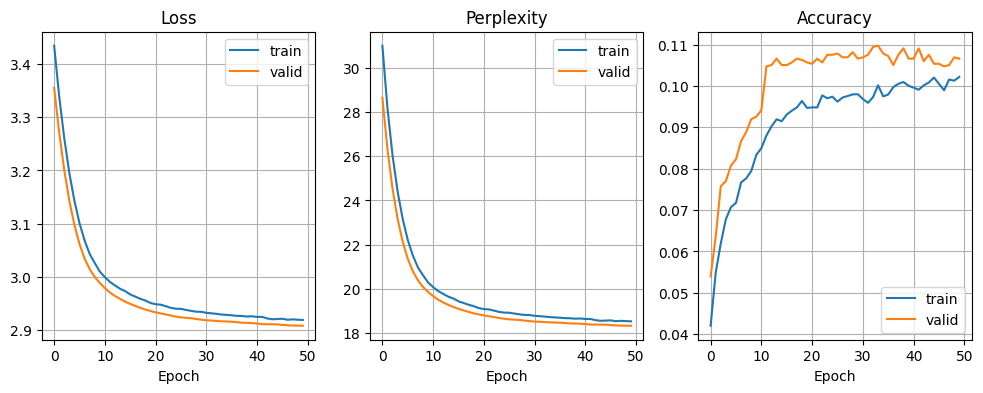

In [67]:
# plot
fig, axs = plt.subplots(1, 3,  figsize = (12, 4))
axs[0].set_title('Loss')
axs[0].plot(history['loss'], label = 'train')
axs[0].plot(history['val-loss'], label = 'valid')
axs[1].set_title('Perplexity')
axs[1].plot(history['ppl'], label = 'train')
axs[1].plot(history['val-ppl'], label = 'valid')
axs[2].set_title('Accuracy')
axs[2].plot(history['acc'], label = 'train')
axs[2].plot(history['val-acc'], label = 'valid')
for ax in axs.flat:
    ax.set(xlabel = 'Epoch')
    ax.grid()
    ax.legend();

In [68]:
# Coloca o modelo em modo de avaliação
modelo_dsa.eval()

# Itera sobre os conjuntos de dados de treino e validação para avaliação
for name, dataset in [("Treino", dataset_treino), ("Validação", dataset_valid)]:
    
    # Escolhe um índice aleatório de uma sequência no conjunto de dados atual
    idx = np.random.choice(len(dataset))
    
    # Extrai a sequência de input_ids e target_ids com base no índice selecionado
    input_ids, target_ids = dataset[idx]
    
    # Desativa o cálculo do gradiente, pois é uma etapa de avaliação
    with torch.no_grad():
        
        # Faz uma previsão usando o modelo e converte o input_ids para um tensor de LongTensor 
        # no dispositivo apropriado
        logits = modelo_dsa(torch.LongTensor([input_ids]).to(device))
    
    # Converte os logits para previsões discretas, usando argmax para selecionar o índice de maior pontuação
    preds = torch.argmax(logits, dim = -1).squeeze(0).detach().cpu().numpy()
    
    # Imprime o nome do conjunto de dados e o índice da sequência avaliada
    print(f"\nSequência de Proteína em {name} com índice {idx}:\n")
    
    # Converte os target_ids de volta para tokens e os exibe
    print("  - Target:   ", " ".join([idx2token[i] for i in target_ids]))
    
    # Converte as previsões para tokens e os exibe
    print("\n  - Previsão:", " ".join([idx2token[i] for i in preds]))
    
    # Calcula a acurácia da previsão comparando com os target_ids
    print("\n  - Acurácia:", np.mean(preds == target_ids))


Sequência de Proteína em Treino com índice 65:

  - Target:    M T Y A L F L L S V I L V M G F V G F S S K P S P I Y G G L V L I I S G A V G C A V I L N C G G G Y M G L M V F L I Y L G G M M V V F G Y T T A M A I E E Y P E A W G S G V E V L V S V L V G L V M E V G L V L W V K E Y D G V V V V V N F N S V G S W M I Y E G E G S G L I R E D P I G A G A L Y D Y G R W L V V V T G W T L F V G V Y V V I E I A R G N <eos>

  - Previsão: M A S S L L L L L S L L L L K L L L L L S S L L S L L L S L L L L L L S L L L L S L L L L L S L L L L L L L L L L L L L L L L L L L L L L L L L L L L L E L L L L L L L L L L L L L L L L L A L L L L L L L L L L L L L L L L L L L L L L L L L S L L S L L L L L L L L L L L L L E L L L L L L L L L L L L L L L A L L L L S L L L A L L L L L L E S L L L L

  - Acurácia: 0.12571428571428572

Sequência de Proteína em Validação com índice 10:

  - Target:    M L S Q K P K K K H N F L N H G L S L N L V I K P Y L A L E G S V A F P A E N G V Q D T E S T Q E K R E T G D E E N

In [69]:
seq = modelo_dsa.generate_sequence()
print(f"Sequência Gerada de Comprimento {len(seq)}:")
print(*seq)

Sequência Gerada de Comprimento 202:
<bos> <pad> L <bos> S M N L I K K T R E D E G Y D I A Q W P H G A E G T S G P K D K T I E T M F P S R U I N K L L C F G P S N L C L T K D T G N A F L R K H C N F E A D G H D S K K R P C L L K S G Q P K P N T D K S N E L B N D Q I G F V E R M I G R F D L R L P P E Q S Q E R S L S W L T L F D A E L K G L L L W N R R Y K P G E Q E S A V L C E A C A T N Q N G P E Q Q A A T V G L N Q I F G N V A V K S S H S L A N G P


In [70]:
# Avalia o modelo
test_loss, test_acc = dsa_avalia_modelo(modelo_dsa, dl_teste, criterion, device, token2idx['<pad>'], vocab_size)

A Perplexidade é uma métrica usada para avaliar modelos de linguagem, como redes neurais baseadas em Transformers, que predizem sequências de texto. Ela mede o quão bem o modelo é capaz de prever uma sequência de palavras e pode ser interpretada como uma medida de incerteza do modelo em relação às suas previsões.

Intuição por trás da Perplexidade:

- A perplexidade está relacionada à probabilidade que o modelo atribui à sequência de palavras correta.
- Perplexidade baixa indica que o modelo está "menos confuso", ou seja, consegue prever a próxima palavra na sequência com maior confiança.
- Perplexidade alta indica que o modelo está "mais confuso", atribuindo probabilidades mais distribuídas entre várias palavras, o que significa que ele está mais incerto sobre a sequência correta.

Interpretação:

- Se a perplexidade é 1, significa que o modelo está totalmente certo sobre qual palavra prever — ele atribui probabilidade 1 ao próximo token correto.
- Se a perplexidade é maior que 1, o modelo está incerto. A perplexidade de 10, por exemplo, indica que o modelo tem a capacidade de escolher entre 10 palavras igualmente prováveis, em média.
- Uma perplexidade próxima do tamanho do vocabulário (digamos, milhares) indicaria que o modelo não aprendeu a prever bem e está atribuindo uma probabilidade quase igual para todas as palavras possíveis.

A perplexidade é diretamente ligada à função de perda de entropia cruzada (Cross-Entropy Loss). De fato, a perplexidade é exponencial à entropia cruzada:

In [71]:
# Exponencial do erro
test_ppl = math.exp(test_loss)

In [72]:
print(f"Erro={test_loss:.4f} - Perplexidade={test_ppl:.4f} - Acurácia={test_acc:.4f}")

Erro=2.8920 - Perplexidade=18.0290 - Acurácia=0.1143


In [73]:
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [74]:
#%watermark -v -m

In [75]:
#%watermark --iversions

# Fim